# Info

Setting up the model to recreate the oscillating basin from the non-hydrostatic manual <br>
[Link to the manual](https://oss.deltares.nl/documents/4142077/4199062/non-hydrostatic_report_draft.pdf/eadc1aff-6e19-6e82-2747-3c11c30457ee?t=1624871720408)


Testing the updated xBeach toolbox to see if it can create the non-hydrostatic model

In [1]:
# import default modules
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D 
from matplotlib import cm
import sys
import os
import subprocess

# Set global constants
PI = np.pi

# method to import xbtools with try routine
try:
    import xbTools
except ImportError:
    print('**no xbTools installation found in environment, adding parent path of notebook to see if it works')
    sys.path.append(r"C:\ERDC\xbeach-toolbox")

**no xbTools installation found in environment, adding parent path of notebook to see if it works


In [2]:
## import xbeach tools
#sys.path.append(os.path.abspath(os.path.join('..' )))

from xbTools.grid.creation import xgrid, ygrid
from xbTools.grid.extension import seaward_extend
from xbTools.xbeachtools import XBeachModelSetup
from xbTools.general.wave_functions import offshore_depth
from xbTools.xbeachpost import XBeachModelAnalysis

C:\ERDC\xbeach-toolbox\xbTools\xbeachtools.py:955: SyntaxWarning: invalid escape sequence '\T'
  ax.text(-thetamin_uv[0], -thetamin_uv[1], '$\Theta_{min}$ = '+f'{self.thetamin:.2f}', ha = 'left', va = 'center')
C:\ERDC\xbeach-toolbox\xbTools\xbeachtools.py:956: SyntaxWarning: invalid escape sequence '\T'
  ax.text(-thetamax_uv[0], -thetamax_uv[1], '$\Theta_{max}$ = '+f'{self.thetamax:.2f}', ha = 'left', va = 'center')


### Import library functions

In [3]:
sys.path.append(r"C:\ERDC\tutorial_models")

from lib.solitary_funcs import (calc_L_scaling, calc_wave_speed, calc_surface_elevation,
                                calc_u_vel, calc_v_vel, calc_depth_average_u)


### Define the model parameters

In [4]:
# Define model parameters
nx = 16000
model_time = 250
num_analy_times = 500
# Define paramters for analytical solution
epsilon = 0.1
g  = 9.81
d0 = 1.0


### Calc the analytical solution

In [5]:
# Model parameters
# The model domain length and simulation time also change with the incident wave height

L_sol = calc_L_scaling(epsilon, delta_scaling=1/20) # Length of the solitary wave
model_length = 100 * L_sol                             # Length of the domain
x0 = -2 * L_sol                                     # Initial x-offset

c = calc_wave_speed(g, epsilon, d0)

print("Scaling wave lengths: {}".format(L_sol))
print("Channel Lengths: {}".format(model_length))
print("x0 Locations: {}".format(x0))
print("Wave speed: {}".format(c))

Scaling wave lengths: 7.953925506456178
Channel Lengths: 795.3925506456178
x0 Locations: -15.907851012912356
Wave speed: 3.2841662030181356


In [6]:
# Set the index for the current wave
index = 0

# Select the first epsilon
epsilon = 0.1

# Select the time arr
time = np.linspace(0, model_time, num_analy_times)

x_location = 0.0
# Calc the x velocity
u_vel = calc_u_vel(epsilon, x0 = x0, x = x_location, y = d0, t = time, g = g, d0 = d0)

# Calc the y velocity
v_vel = calc_v_vel(epsilon, x0 = x0, x = x_location, y = d0, t = time, g = g, d0 = d0)

# Calc the water surface elevation
eta = calc_surface_elevation(epsilon, x0, x= x_location, t = time, g = g, d0 = d0)

# Calc the average u velocity
u_avg = calc_depth_average_u(epsilon, x0, x = x_location, t = time, g = g, d0 = d0)

### Generate the mesh

In [7]:
# Generate the x-mesh
xgr = np.linspace(0, model_length, nx+1)

# Set the y-mesh as none since the model is 1D
ygr = None

# Generate the bathymetry
floor_depth = 0.0
zgr = np.ones(nx+1) * floor_depth


### Create the model setup
Generating the model setup using the xBeach toolbox

In [8]:
xb_setup = XBeachModelSetup('test')

xb_setup.set_grid(xgr, ygr, zgr, posdwn=-1, alfa=0)
xb_setup.set_nebed(np.ones_like(zgr))
xb_setup.set_friction(np.ones_like(zgr))

In [9]:
boun_U_dict = {"make_file": True,
               "file_name": "boun_U.bcf",
               "dimension": "vector",
               "variable_dict": {
                   "t" : time,
                   "U" : u_avg,
                   "zs": eta - d0
               }         
}

xb_setup.set_waves('ts_nonh', input_struct=boun_U_dict)


In [10]:
# For the time being including the wbctype here so that it can be added to the physical process location
xb_setup.set_params({"wbctype"      : "ts_nonh",
                     'wavemodel'    : 'nonh',
                     'CFL'          : 0.75,
                     'bedfriccoef'  : 0.0,
                     'morphology'   : 0,
                     "rugdepth"     : 0.010000,
                     'zs0'          : 1,
                     'order'        : 1,

                     'front'        : "nonh_1d", 'back'         : "abs_1d" ,
                     'left'         : "neumann", 'right'        : "neumann",

                     'tstop'        : time.max(),
                     
                     "tintm"        : 0.1,
                     "tintp"        : 0.1,
                     "tintg"        : 0.1,
                     'nglobalvar'   : ['zs', 'zb', 'H'],
})


In [11]:
xb_setup.input_par

{'par': {'rugdepth': 0.01},
 'Wave boundary condition parameters': {'wbctype': 'ts_nonh'},
 'Physical processes': {'wavemodel': 'nonh', 'morphology': 0},
 'Model time': {'CFL': 0.75, 'tstop': 250.0},
 'Flow parameters': {'bedfriccoef': 0.0},
 'Tide boundary conditions': {'zs0': 1},
 'Flow boundary condition parameters': {'order': 1,
  'front': 'nonh_1d',
  'back': 'abs_1d',
  'left': 'neumann',
  'right': 'neumann'},
 'Output': {'tintm': 0.1, 'tintp': 0.1, 'tintg': 0.1},
 '_Output': {'nglobalvar': ['zs', 'zb', 'H']}}

In [12]:
def get_script_directory():
    try:
        # This will work if the script is run directly
        script_path = os.path.abspath(__file__)
    except NameError:
        # This will work in an interactive environment like Jupyter
        script_path = os.path.abspath('')
    
    return script_path

# Get the folder of the current script
model_dir = get_script_directory()

print("Model directory is: {}".format(model_dir))

xb_setup.write_model(model_dir)

Model directory is: c:\ERDC\tutorial_models\solitary_wave\3_sol_wave_nx_16000_tstop_250_CFL_075_toolbox_test
Data written to c:\ERDC\tutorial_models\solitary_wave\3_sol_wave_nx_16000_tstop_250_CFL_075_toolbox_test\boun_U.bcf


### Generate the boun_U.bcf file

In [13]:
def get_script_directory():
    try:
        # This will work if the script is run directly
        script_path = os.path.abspath(__file__)
    except NameError:
        # This will work in an interactive environment like Jupyter
        script_path = os.path.abspath('')
    
    return script_path

# Get the folder of the current script
model_dir = get_script_directory()

print("Model directory is: {}".format(model_dir))

Model directory is: c:\ERDC\tutorial_models\solitary_wave\3_sol_wave_nx_16000_tstop_250_CFL_075_toolbox_test


In [14]:
# Specify the path to your batch file
batch_file = os.path.join(model_dir, r"run_model.bat")

# Run the batch file
try:
    subprocess.run(batch_file, check=True, shell=True)
    print(f"Batch file '{batch_file}' executed successfully.")
except subprocess.CalledProcessError as e:
    print(f"An error occurred while executing the batch file: {e}")

Batch file 'c:\ERDC\tutorial_models\solitary_wave\3_sol_wave_nx_16000_tstop_250_CFL_075_toolbox_test\run_model.bat' executed successfully.


In [15]:
results = XBeachModelAnalysis(fname = "foo", 
                              model_path=model_dir)

In [16]:
results.set_save_fig(False)
results.set_plot_localcoords(False)
results.set_plot_km_coords(False)

loading variable zs from file
loading variable zb from file
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded
Variable already loaded


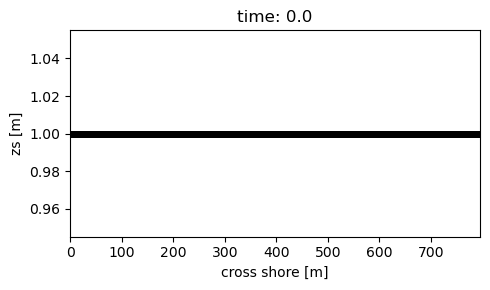

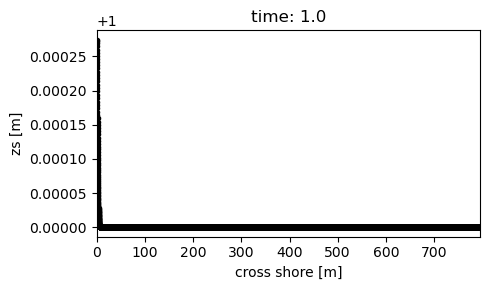

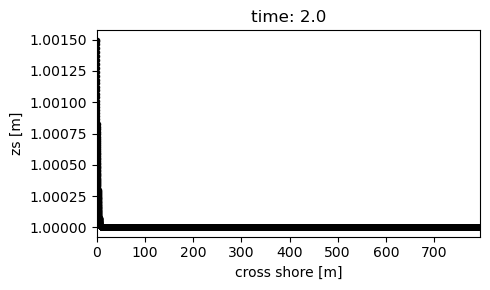

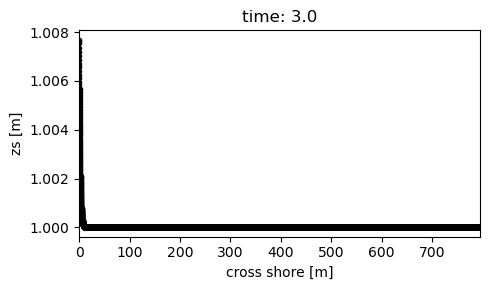

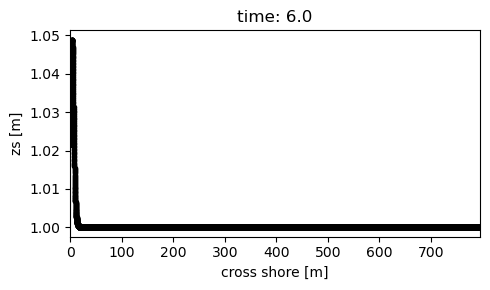

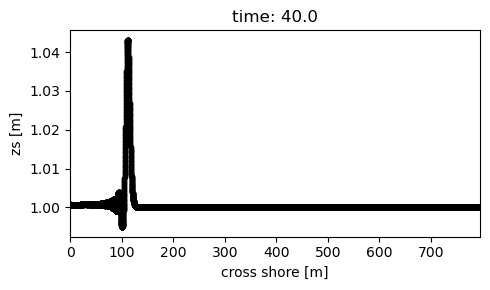

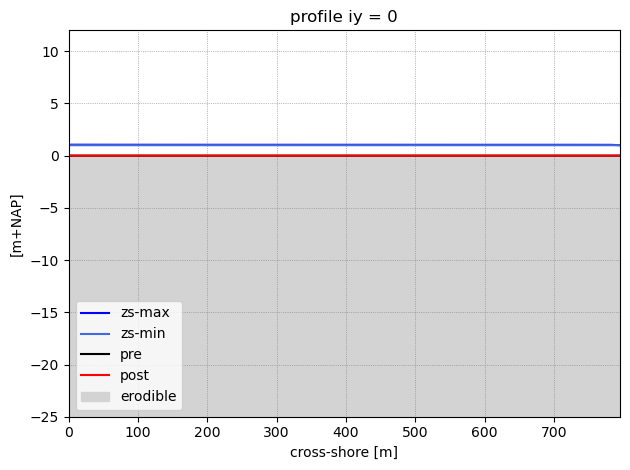

In [17]:
indices = [0, 10, 20, 30, 60, 400]

for index in indices:
    fig, ax = results.fig_cross_var('zs', index, iy=0, coord=None, plot_ref_bathy=False, zmin=-1)

fig, ax = results.fig_profile_change(iy=0)

In [18]:
time = results.var["globaltime"]
zs = results.var["zs"]

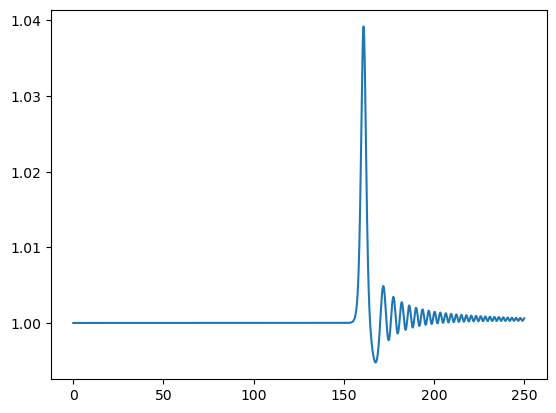

In [23]:
zs_0 = results.var["zs"][:, 0, 10000]

plt.plot(time, zs_0)